In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('/kaggle/input/airlines-delay/airlines_delay.csv')

In [34]:
X = df.iloc[:35000,1:-1].values
y = df.iloc[:35000,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [4]:
if(torch.cuda.is_available()):
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [5]:
df = pd.read_csv('/kaggle/input/airlines-delay/airlines_delay.csv')

In [16]:
df['AirportTo']=LabelEncoder().fit_transform(df['AirportTo'])
df['AirportFrom']=LabelEncoder().fit_transform(df['AirportFrom'])
df['Airline']=LabelEncoder().fit_transform(df['Airline'])

In [17]:
df[['Time','Length']]=MinMaxScaler().fit_transform(df[['Time','Length']])

In [8]:
class MLP(nn.Module):
    def __init__(self, n_input, P, C):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_input, P),
            nn.ReLU(),
            nn.Linear(P, C)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [35]:
def train(P, samples, labels):
    N = len(labels)
    model = MLP(6, P, 2).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_function = nn.CrossEntropyLoss()
    n_epochs, losses = 3, []
    model.train()
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0
#         print('Epoch: {}'.format(epoch))
        for sample, label in zip(samples, labels):
            optimizer.zero_grad()
            pred = model(sample.to(device))
            loss = loss_function(pred, label.to(device))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
#         print('Epoch: {}, Loss: {}'.format(epoch, running_loss / N))
        losses.append(running_loss / N)
    return model, np.mean(losses)

In [10]:
def predict(model, samples):
    model.eval()
    predictions = []
    with torch.no_grad():
        for sample in samples:
            pred = model(sample.to(device))
            predictions.append(np.argmax(pred.cpu().numpy()))
    return predictions

In [36]:
def k_fold(samples, labels, k=10, total_perceptrons=10):
    fig, ax = plt.subplots(figsize=(10, 8))
    N = len(labels)
    min_error, min_error_neurons = np.Inf, -1
    errors_, perceptrons = [], []
    kf = KFold(n_splits=k, shuffle=True)
    for p in range(3, total_perceptrons):
        errors = []
        for train_indices, valid_indices in kf.split(samples):
            samples = np.vstack(samples).astype(float)
            training_samples = torch.FloatTensor(samples[train_indices])
            training_labels = torch.LongTensor(labels[train_indices])
            validation_samples = torch.FloatTensor(samples[valid_indices])
            validation_labels = labels[valid_indices]
            
            model, _ = train(p, training_samples, training_labels)
            pred = predict(model, torch.FloatTensor(validation_samples))
            error = (sum([pred[i] != validation_labels[i] for i in range(validation_labels.shape[0])]) /
                     validation_labels.shape[0])
            errors.append(error)
        mean_error = np.mean(errors)
        perceptrons.append(p)
        errors_.append(mean_error)
        if mean_error < min_error:
            min_error = mean_error
            min_error_neurons = p
    print('{} perceptrons result in minimum error of {:.4f}'.format(min_error_neurons, min_error))

    ax.plot(perceptrons, errors_)
    ax.set_title("Cross-Validation -> Mean probability of error vs Number of perceptrons")
    ax.set_xlabel('Perceptrons')
    ax.set_ylabel("Pr(error)")
    ax.legend()
    plt.show()

    return np.argmin(errors_) + 1

In [12]:
def training(samples, labels, best_n_perceptrons=1):
    model_info = {'best_model': None, 'loss': np.Inf}
    for i in range(1):
        model, loss = train(best_n_perceptrons, torch.FloatTensor(samples), torch.LongTensor(labels))
        if loss < model_info['loss']:
            model_info = {'best_model': model, 'loss': loss}
#     print('Best Model has loss of ', model_info['loss'])
    return model_info['best_model']


def testing(samples, labels, model):
    pred = predict(model, torch.FloatTensor(samples))
    error = (sum([pred[i] != labels[i] for i in range(labels.shape[0])]) /
             labels.shape[0])
    print('Test set has loss of ', error)
    return error, pred

100%|██████████| 3/3 [00:57<00:00, 19.00s/it]


3 perceptrons result in minimum error of 0.1450


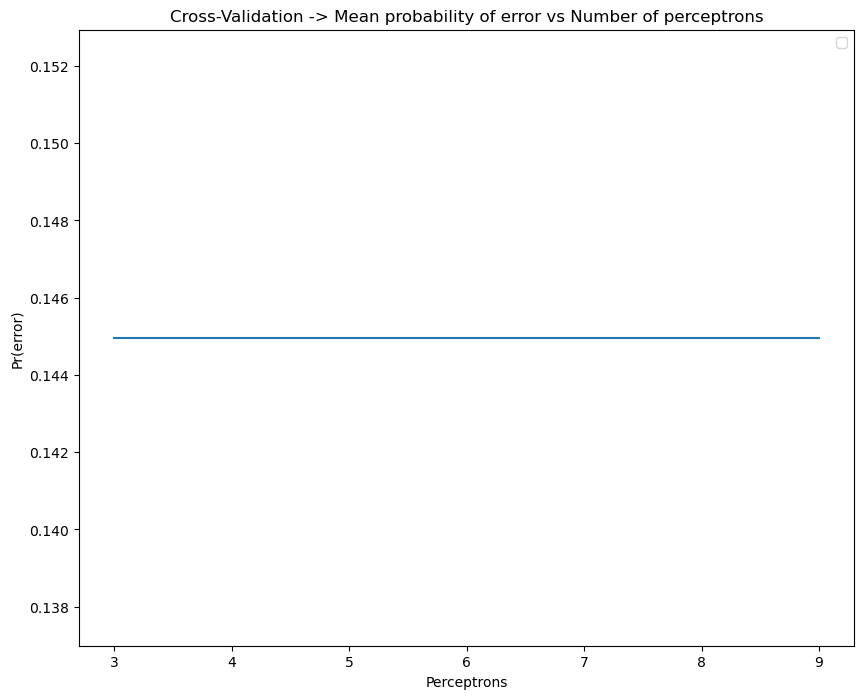

1

In [37]:
k_fold(X_train, y_train, k=5, total_perceptrons=10)

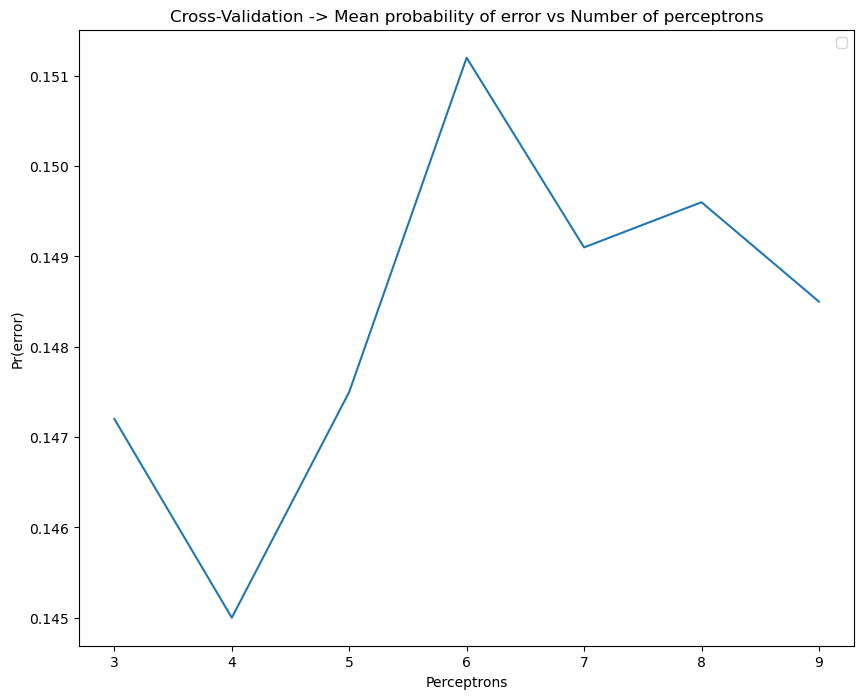

In [45]:
# Ignore the above graph

In [43]:
MLP_model = training(X_train, y_train, 4)

100%|██████████| 3/3 [01:11<00:00, 23.73s/it]

Best Model has loss of  0.41581332009758304


In [44]:
MLP_error, MLP_pred = testing(X_test, y_test, MLP_model)

Test set has loss of  0.14714285714285713


In [40]:
MLP_error

0.14714285714285713